# Use Case: Study Amazon Estuaries with Data from the EOSDIS Cloud

<img src="https://cdn.earthdata.nasa.gov/conduit/upload/12946/EOSDISCloud-logo.jpg" width="45%" />

<p><left>Read more about the EOSDIS Cloud at <a href="https://earthdata.nasa.gov/eosdis/cloud-evolution" >NASA Earthdata</a>.</center></p>

## Overview

This tutorial uses satellite data products to analyze the relationships between river height and land water equivalent thickness in the Amazon River estuary. Users can expand on these examples to also include sea surface salinity, sea surface temperature, and ocean color for example, for a more comprehensive exploration of the Amazon river basin's estuary and coastal region.
The contents are useful for the ocean, coastal and terrestrial hydrosphere disciplines, showcasing how to use on premises and Earthdata cloud datasets, existing Earthdata cloud services and functionalities, and Earthdata User Interface (UI) and Application Programming Interfaces (API).

### Learning objectives:

* Search for land water equivalent (LWE) thickness (GRACE/GRACE-FO) and river discharge data (MEaSUREs Pre-SWOT)
* Access LWE thickeness dataset in Zarr format from Earthdata Cloud (AWS) using the Harmony API (specifically the Zarr reformatted service)
* Access discharge dataset from PODAAC on premise (server) data archive
* Subset both, plot and compare coincident data.

### Datasets

The tutorial uses a combination of cloud and on premises datasets:
- [**JPL GRACE and GRACE-FO Mascon Ocean, Ice, and Hydrology Equivalent Water Height Coastal Resolution Improvement (CRI) Filtered Release 06 Version 02**](https://podaac.jpl.nasa.gov/dataset/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2)
    - Provides land water equivalent (LWE) thickness for observing seasonal changes in water storage around the river. When discharge is high, the change in water storage will increase, pointing to a wet season. Source data are from [GRACE](https://podaac.jpl.nasa.gov/GRACE) and [GRACE-FO](https://podaac.jpl.nasa.gov/GRACE-FO).
- [**Pre SWOT Hydrology GRRATS Daily River Heights and Storage Version 2**](https://podaac.jpl.nasa.gov/dataset/PRESWOT_HYDRO_GRRATS_L2_DAILY_VIRTUAL_STATION_HEIGHTS_V2)
    - Provides virtual gauges to stand in for discharge data from Surface Water and Ocean Topography (SWOT). MEaSUREs contains river height products, not discharge, but river height is directly related to discharge and thus will act as a good substitute. Data were produced for the [Pre-SWOT Making Earth System Data Records for Use in Research Environments (MEaSUREs)](https://podaac.jpl.nasa.gov/MEaSUREs-Pre-SWOT) Program.

### Requirements

This notebook was developed to run in the AWS cloud (us-west-2 region), next to the Earthdata Cloud (PO.DAAC) data holdings, to leverage cloud optimized data formats (e.g. Zarr) and the Earthdata Harmony API, specifically the Zarr refomrating service. For more informaion on Harmony, please see https://harmony.earthdata.nasa.gov/ .

In order to currently access PO.DAAC Cloud Pathfinder datasets such as GRACE/GRACE-FO from the Earthdata Cloud, your Earthdata login *username* needs to be added to a restricted early access list (during the transition period of migrating PO.DAAC data to the Earthdata Cloud). Please contact podaac@podaac.jpl.nasa.gov to make that request.

This notebook was developed in Python 3.6 and depends on the following Python packages:

In [1]:
import time
import requests
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cartopy.crs as ccrs
import cartopy
import zarr
import s3fs
from IPython.display import HTML
from json import dumps, loads

### Endpoints

Set a few endpoints for use during the remainder of the workflow:

In [2]:
cmr = "cmr.earthdata.nasa.gov"
urs = "urs.earthdata.nasa.gov"
harmony = "harmony.earthdata.nasa.gov"

cmr, urs, harmony

('cmr.earthdata.nasa.gov',
 'urs.earthdata.nasa.gov',
 'harmony.earthdata.nasa.gov')

### NASA Earthdata Login Setup

An Earthdata Login account is required to access data, as well as discover restricted data, from the NASA Earthdata system. Please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account. This account is free to create and only takes a moment to set up.

The setup_earthdata_login_auth function will allow Python scripts to log into any Earthdata Login application programmatically. To avoid being prompted for credentials every time you run and also allow clients such as curl to log in, you can add the following to a .netrc (\_netrc on Windows) file in your home directory:

```shell
machine urs.earthdata.nasa.gov
    login <your username>
    password <your password>
```
   
Make sure that this file is only readable by the current user or you will receive an error stating "netrc access too permissive."

```shell
$ chmod 0600 ~/.netrc
```

*You will be prompted for your username and password if you dont have a netrc file. Note: these imports are all in the Python 3.6+ standard library.*

In [3]:
from platform import system
from netrc import netrc
from getpass import getpass
from urllib import request
from http.cookiejar import CookieJar
from os.path import join, expanduser

TOKEN_DATA = ("<token>"
              "<username>%s</username>"
              "<password>%s</password>"
              "<client_id>PODAAC CMR Client</client_id>"
              "<user_ip_address>%s</user_ip_address>"
              "</token>")


def setup_earthdata_login_auth(urs: str='urs.earthdata.nasa.gov', cmr: str='cmr.earthdata.nasa.gov'):

    # GET URS LOGIN INFO FROM NETRC OR USER PROMPTS:
    netrc_name = "_netrc" if system()=="Windows" else ".netrc"
    try:
        username, _, password = netrc(file=join(expanduser('~'), netrc_name)).authenticators(urs)
        print("# Your URS credentials were securely retrieved from your .netrc file.")
    except (FileNotFoundError, TypeError):
        print('# Please provide your Earthdata Login credentials for access.')
        print('# Your info will only be passed to %s and will not be exposed in Jupyter.' % (urs))
        username = input('Username: ')
        password = getpass('Password: ')

    # SET UP URS AUTHENTICATION FOR HTTP DOWNLOADS:
    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, urs, username, password)
    auth = request.HTTPBasicAuthHandler(manager)
    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)

    # GET TOKEN TO ACCESS RESTRICTED CMR METADATA:
    ip = requests.get("https://ipinfo.io/ip").text.strip()
    r = requests.post(
        url="https://%s/legacy-services/rest/tokens" % cmr,
        data=TOKEN_DATA % (str(username), str(password), ip),
        headers={'Content-Type': 'application/xml', 'Accept': 'application/json'}
    )
    return r.json()['token']['id']


# Provide URS credentials for HTTP download auth & CMR token retrieval:
_token = setup_earthdata_login_auth(urs=urs, cmr=cmr)

# Your URS credentials were securely retrieved from your .netrc file.


## Cloud data from JPL GRACE and GRACE-FO Mascon

![grace mascon](https://podaac.jpl.nasa.gov/Podaac/thumbnails/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2.jpg)

**JPL GRACE and GRACE-FO Mascon Ocean, Ice, and Hydrology Equivalent Water Height Coastal Resolution Improvement (CRI) Filtered Release 06 Version 02**

This dataset contains gridded monthly global water storage/height anomalies relative to a time-mean, derived from GRACE and GRACE-FO and processed at JPL using the Mascon approach (Version2/RL06). These data are provided in a single data file in netCDF format, and can be used for analysis for ocean, ice, and hydrology phenomena. This version of the data employs a Coastal Resolution Improvement (CRI) filter that reduces signal leakage errors across coastlines. The water storage/height anomalies are given in equivalent water thickness units (cm). The solution provided here is derived from solving for monthly gravity field variations in terms of geolocated spherical cap mass concentration functions, rather than global spherical harmonic coefficients. Additionally, realistic geophysical information is introduced during the solution inversion to intrinsically remove correlated error. Thus, these Mascon grids do not need to be destriped or smoothed, like traditional spherical harmonic gravity solutions. The complete Mascon solution consists of 4,551 relatively independent estimates of surface mass change that have been derived using an equal-area 3-degree grid of individual mascons. A subset of these individual mascons span coastlines, and contain mixed land and ocean mass change signals. 

For more information, please visit https://grace.jpl.nasa.gov/data/get-data/jpl_global_mascons/. 

For a detailed description on the Mascon solution, including the mathematical derivation, implementation of geophysical constraints, and solution validation, please see Watkins et al., 2015, doi: 10.1002/2014JB011547. For a detailed description of the CRI filter implementation, please see Wiese et al., 2016, doi: 10.1002/2016WR019344.

### Metadata

Data from the [TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2](https://podaac.jpl.nasa.gov/dataset/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2) dataset can be obtained from AWS S3. Use its *ShortName* to retrieve the *collection* metadata from CMR:

In [4]:
grace_ShortName = "TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2"
grace_ShortName

'TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2'

#### Collection (dataset)

Get the UMM Collection metadata using `requests.get`:

In [5]:
r = requests.get(url=f"https://{cmr}/search/collections.umm_json", 
                 params={'provider': "POCLOUD", 
                         'ShortName': grace_ShortName, 
                         'token': _token})

grace_coll = r.json()
grace_coll['hits']

1

There should be only one result. Select and print its CMR Search metadata:

In [6]:
grace_coll_meta = grace_coll['items'][0]['meta']
grace_coll_meta

{'revision-id': 2,
 'deleted': False,
 'format': 'application/vnd.nasa.cmr.umm+json',
 'provider-id': 'POCLOUD',
 'user-id': 'cia001',
 'has-formats': False,
 'has-spatial-subsetting': False,
 'native-id': 'JPL+GRACE+and+GRACE-FO+Mascon+Ocean,+Ice,+and+Hydrology+Equivalent+Water+Height+Coastal+Resolution+Improvement+(CRI)+Filtered+Release+06+Version+02',
 'has-transforms': False,
 'has-variables': False,
 'concept-id': 'C1938032626-POCLOUD',
 'revision-date': '2020-09-14T16:14:13.718Z',
 'granule-count': 0,
 'has-temporal-subsetting': False,
 'concept-type': 'collection'}

#### Granule (file)

Get the UMM Granule metadata using `requests.get`:

In [7]:
r = requests.get(url=f"https://{cmr}/search/granules.umm_json", 
                 params={'provider': "POCLOUD", 
                         'ShortName': grace_ShortName, 
                         'token': _token})

grace_gran = r.json()
grace_gran['hits']

4

As you can see, one result was returned (one *hit*). Print the CMR Search metadata for the granule (`meta`):

In [8]:
grace_gran['items'][0]['meta']

{'concept-type': 'granule',
 'concept-id': 'G1965295346-POCLOUD',
 'revision-id': 1,
 'native-id': 'GRCTellus.JPL.200204_202009.GLO.RL06M.MSCNv02CRI',
 'provider-id': 'POCLOUD',
 'format': 'application/vnd.nasa.cmr.umm+json',
 'revision-date': '2020-11-10T18:37:10.446Z'}

The other component in each result (from the list of `items`) is the UMM metadata, accessible from the `umm` key. Print the *RelatedUrls* metadata field for the granule:

In [9]:
grace_gran['items'][0]['umm']['RelatedUrls']

[{'URL': 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2/GRCTellus.JPL.200204_202009.GLO.RL06M.MSCNv02CRI.cmr.json',
  'Type': 'EXTENDED METADATA',
  'Description': 'File to download'},
 {'URL': 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2/GRCTellus.JPL.200204_202009.GLO.RL06M.MSCNv02CRI.nc',
  'Type': 'GET DATA',
  'Description': 'File to download'},
 {'URL': 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2/GRCTellus.JPL.200204_202009.GLO.RL06M.MSCNv02CRI.nc.md5',
  'Type': 'EXTENDED METADATA',
  'Description': 'File to download'}]

We want the URL corresponding to `'Type': 'GET DATA'`. Select the URL from appropriate item in the list, then print:

In [10]:
grace_url = grace_gran['items'][0]['umm']['RelatedUrls'][1]['URL']
grace_url

'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2/GRCTellus.JPL.200204_202009.GLO.RL06M.MSCNv02CRI.nc'

Then, to do a regular HTTPS download:
    
```python
r = requests.get(grace_url)
with open('tutorial7_data_GRACEFO.nc', 'wb') as f:
    f.write(r.content)

!ncdump -h tutorial7_data_GRACEFO.nc
```

But we'll use the Harmony API's Zarr Reformatter service instead of downloading the entire granule. The zarr format will allow us to open and download/read just the data that we require for our Amazon Basin study area.

### Request to Harmony API: Zarr Reformatter 

If you have a `jobID` you'd like to re-visit instead of running this command again, modify the cell below to set the *async_jobId* then skip the one immediately after. You can continue from 'Query for the job status and links'.

*If you are running for the first time, proceed to the next cells to submit the harmony request.*

In [11]:
#async_jobId = "dfefc536-768c-4db3-a7d2-c326e9253042"  # jobId belongs to dev. You wont have access.
async_jobId = None 

*See important usage note below if this is your first time submitting a request to the Zarr Reformatter service.*

The Zarr Reformatter service operates on an input Collection *concept-id* (a CMR construct). The service will accept more user-friendly inputs (like a Collection *ShortName*) in future releases. Here's how you identify the CMR *concept-id* for the JPL GRACE/GRACE-FO Mascon dataset:

In [12]:
collection_concept_id = grace_coll_meta['concept-id']
collection_concept_id

'C1938032626-POCLOUD'

Most of this next cell will only evaluate if there's NOT a valid job identifier set to the `async_jobId` variable above. It submits the Harmony request, and prints the JSON response.

In [13]:
async_url = f'https://{harmony}/{collection_concept_id}/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?format=application/x-zarr'
if async_jobId is None:
    print('Request URL: ', async_url)
    async_response = request.urlopen(async_url)
    async_results = async_response.read()
    async_json = loads(async_results)
    print(dumps(async_json, indent=2))
    async_jobId = async_json['jobID']

Request URL:  https://harmony.earthdata.nasa.gov/C1938032626-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?format=application/x-zarr
{
  "username": "jmcnelis",
  "status": "running",
  "message": "The job is being processed",
  "progress": 0,
  "createdAt": "2021-03-15T22:14:46.364Z",
  "updatedAt": "2021-03-15T22:14:46.364Z",
  "links": [
    {
      "title": "Job Status",
      "href": "https://harmony.earthdata.nasa.gov/jobs/8a23583d-9889-4f7c-9ac7-d078ab17dc69",
      "rel": "self",
      "type": "application/json"
    }
  ],
  "request": "https://harmony.earthdata.nasa.gov/C1938032626-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?format=application%2Fx-zarr",
  "numInputGranules": 4,
  "jobID": "8a23583d-9889-4f7c-9ac7-d078ab17dc69"
}


Format and display the complete url to the Harmony API job:

In [14]:
job_url = f'https://{harmony}/jobs/{async_jobId}'
job_url

'https://harmony.earthdata.nasa.gov/jobs/8a23583d-9889-4f7c-9ac7-d078ab17dc69'

Query for the job status and links in case the request is still processing:

In [15]:
while True:
    loop_response = request.urlopen(job_url)
    loop_results = loop_response.read()
    job_json = loads(loop_results)
    if job_json['status'] != 'running':
        break
    print(f"# Job status is running. Progress is {job_json['progress']}. Trying again.")
    time.sleep(5)

links = []
if job_json['status'] == 'successful' and job_json['progress'] == 100:
    print("# Job progress is 100%. Links to job outputs are displayed below:")
    links = [link['href'] for link in job_json['links']]
    display(links)

# Job status is running. Progress is 0. Trying again.
# Job status is running. Progress is 0. Trying again.
# Job status is running. Progress is 0. Trying again.
# Job status is running. Progress is 0. Trying again.
# Job status is running. Progress is 0. Trying again.
# Job status is running. Progress is 0. Trying again.
# Job status is running. Progress is 0. Trying again.
# Job status is running. Progress is 0. Trying again.
# Job status is running. Progress is 0. Trying again.
# Job status is running. Progress is 0. Trying again.
# Job status is running. Progress is 0. Trying again.
# Job status is running. Progress is 0. Trying again.
# Job status is running. Progress is 0. Trying again.
# Job status is running. Progress is 0. Trying again.
# Job status is running. Progress is 0. Trying again.
# Job status is running. Progress is 0. Trying again.
# Job status is running. Progress is 0. Trying again.
# Job status is running. Progress is 0. Trying again.
# Job status is running. Pro

['https://harmony.earthdata.nasa.gov/jobs/8a23583d-9889-4f7c-9ac7-d078ab17dc69',
 'https://harmony.earthdata.nasa.gov/stac/8a23583d-9889-4f7c-9ac7-d078ab17dc69/',
 'https://harmony.earthdata.nasa.gov/cloud-access.sh',
 'https://harmony.earthdata.nasa.gov/cloud-access',
 's3://harmony-prod-staging/public/harmony/netcdf-to-zarr/e89a4be7-1916-4a07-bb35-6b1b399afe74/',
 's3://harmony-prod-staging/public/harmony/netcdf-to-zarr/e89a4be7-1916-4a07-bb35-6b1b399afe74/GRCTellus.JPL.200204_202009.GLO.RL06M.MSCNv02CRI.zarr',
 's3://harmony-prod-staging/public/harmony/netcdf-to-zarr/e89a4be7-1916-4a07-bb35-6b1b399afe74/GRCTellus.JPL.200204_202010.GLO.RL06M.MSCNv02CRI.zarr',
 's3://harmony-prod-staging/public/harmony/netcdf-to-zarr/e89a4be7-1916-4a07-bb35-6b1b399afe74/GRCTellus.JPL.200204_202011.GLO.RL06M.MSCNv02CRI.zarr',
 's3://harmony-prod-staging/public/harmony/netcdf-to-zarr/e89a4be7-1916-4a07-bb35-6b1b399afe74/GRCTellus.JPL.200204_202012.GLO.RL06M.MSCNv02CRI.zarr']

**Access url for the output zarr file**

The new zarr dataset is staged for us in an S3 bucket. The url is the last one in the list shown above.

Select the url and display below:

In [16]:
zarr_url = links[-1]
zarr_url

's3://harmony-prod-staging/public/harmony/netcdf-to-zarr/e89a4be7-1916-4a07-bb35-6b1b399afe74/GRCTellus.JPL.200204_202012.GLO.RL06M.MSCNv02CRI.zarr'

**Access credentials for the output zarr file**

Credentials provided at the third and fourth urls in the list grant authenticated access to your staged S3 resources.

Grab the credentials as a JSON string, load to a Python dictionary, and display their expiration date:

In [17]:
with request.urlopen(f"https://{harmony}/cloud-access") as f:
    creds = loads(f.read())

creds['Expiration']

'2021-03-16T06:17:33.000Z'

### Open staged zarr file with *s3fs*

We use the AWS `s3fs` package to get metadata about the zarr data store and list its contents:

In [18]:
zarr_fs = s3fs.S3FileSystem(
    key=creds['AccessKeyId'],
    secret=creds['SecretAccessKey'],
    token=creds['SessionToken'],
    client_kwargs={'region_name':'us-west-2'},
)
zarr_store = zarr_fs.get_mapper(root=zarr_url, check=False)
zarr_dataset = zarr.open(zarr_store)

print(zarr_dataset.tree())

/
 ├── lat (360,) float64
 ├── lat_bounds (360, 2) float64
 ├── lon (720,) float64
 ├── lon_bounds (720, 2) float64
 ├── lwe_thickness (192, 360, 720) float64
 ├── time (192,) float64
 ├── time_bounds (192, 2) float64
 └── uncertainty (192, 360, 720) float64


Now print metadata for the *lwe_thickness* variable:

In [19]:
print(zarr_dataset.lwe_thickness.info)

Name               : /lwe_thickness
Type               : zarr.core.Array
Data type          : float64
Shape              : (192, 360, 720)
Chunk shape        : (192, 360, 720)
Order              : C
Read-only          : False
Compressor         : Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)
Store type         : fsspec.mapping.FSMap
No. bytes          : 398131200 (379.7M)
Chunks initialized : 1/1



### Open staged zarr file with *xarray*

Here's the documentation for `xarray`'s zarr reader: http://xarray.pydata.org/en/stable/generated/xarray.open_zarr.html

Open the zarr dataset and print the dataset "header":

In [20]:
ds_GRACE = xr.open_zarr(zarr_store)
print(ds_GRACE)

<xarray.Dataset>
Dimensions:        (bounds: 2, lat: 360, lon: 720, time: 192)
Coordinates:
  * lat            (lat) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * lon            (lon) float64 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * time           (time) datetime64[ns] 2002-04-17T12:00:00 ... 2020-12-16T1...
Dimensions without coordinates: bounds
Data variables:
    lat_bounds     (lat, bounds) float64 dask.array<chunksize=(360, 2), meta=np.ndarray>
    lon_bounds     (lon, bounds) float64 dask.array<chunksize=(720, 2), meta=np.ndarray>
    lwe_thickness  (time, lat, lon) float64 dask.array<chunksize=(192, 360, 720), meta=np.ndarray>
    time_bounds    (time, bounds) datetime64[ns] dask.array<chunksize=(192, 2), meta=np.ndarray>
    uncertainty    (time, lat, lon) float64 dask.array<chunksize=(192, 360, 720), meta=np.ndarray>
Attributes: (12/53)
    CRI_filter_journal_reference:  Wiese, D. N., F. W. Landerer, and M. M. Wa...
    C_20_substitution:             TN-14;

**Subset by Latitude/Longitude**

Once we have obtained all the data, to make processing quicker, we are going to subset datasets by latitude/longitude for the Amazon River estuary.

Once we have obtained the GRACE-FO data, we should spatial subset the data to the minimal area covering the Amazon River estuary. This will reduce processing load and reduce cloud costs for the user.

Make a GRACE-FO subset and display the min, max of the *lat* and *lon* variables:

In [21]:
subset_GRACE = ds_GRACE.sel(lat=slice(-18, 10), lon=slice(275, 330))
print(subset_GRACE.lat.min().data, 
      subset_GRACE.lat.max().data,
      subset_GRACE.lon.min().data,
      subset_GRACE.lon.max().data)

-17.75 9.75 275.25 329.75


**Select the variable for Land Water Equivalent Thickness (*lwe_thickness*)**

Grab the land water equivalent thickness variable from the GRACE subset:

In [22]:
lwe = subset_GRACE.lwe_thickness
print(lwe)

<xarray.DataArray 'lwe_thickness' (time: 192, lat: 56, lon: 110)>
dask.array<getitem, shape=(192, 56, 110), dtype=float64, chunksize=(192, 56, 110), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -17.75 -17.25 -16.75 -16.25 ... 8.25 8.75 9.25 9.75
  * lon      (lon) float64 275.2 275.8 276.2 276.8 ... 328.2 328.8 329.2 329.8
  * time     (time) datetime64[ns] 2002-04-17T12:00:00 ... 2020-12-16T12:00:00
Attributes:
    comment:        Coastline Resolution Improvement (CRI) filter is applied
    grid_mapping:   WGS84
    long_name:      Liquid_Water_Equivalent_Thickness
    standard_name:  Liquid_Water_Equivalent_Thickness
    units:          cm
    valid_max:      778.7073956181606
    valid_min:      -1719.8593624513596


### Plots

We will create an animation from sequential GRACE-FO plots over the Amazon Rainforest in the following cells. Define two functions to make the process a bit more convenient:

In [23]:
def setup_map(ax, pmap, ds_subset, x, y, var, t, cmap, levels, extent):
    title = str(pd.to_datetime(ds_subset.time[t].values))
    pmap.set_title(title, fontsize=14)
    pmap.coastlines()
    pmap.set_extent(extent)
    pmap.add_feature(cartopy.feature.RIVERS)
    variable_desired = var[t,:,:]
    cont = pmap.contourf(x, y, variable_desired, cmap=cmap, levels=levels, zorder=1)
    return cont

def animate_ts(framenumber, ax, pmap, ds_subset, x, y, var, t, cmap, levels, extent):
    cont = setup_map(ax, pmap, ds_subset, x, y, var, t + framenumber, cmap, levels, extent) 
    return cont

Plot the first timestep in the JPL GRACE/GRACE-FO Mascon time series:

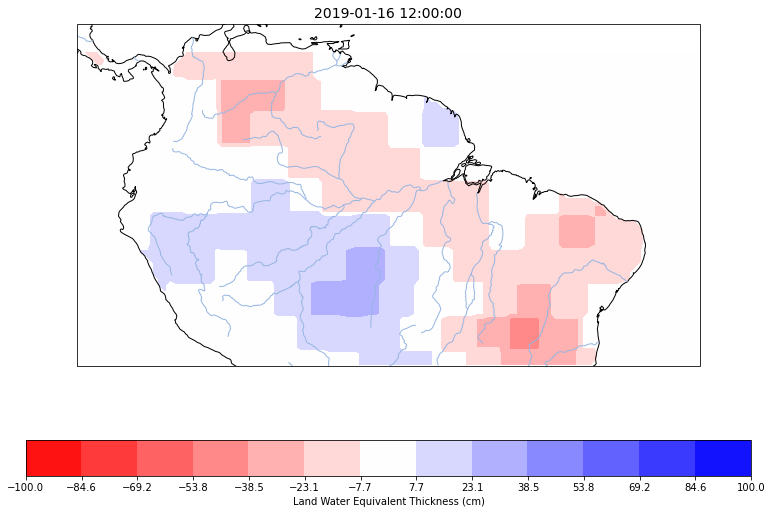

In [24]:
# Initialize a matplotlib plot object and add subplot:
fig = plt.figure(figsize=[13,9]) 
ax = fig.add_subplot(1, 1, 1)

# Configure axes to display projected data using PlateCarree crs:
pmap = plt.axes(projection=ccrs.PlateCarree())

# Get arrays of x and y to label the plot axes:
x,y = np.meshgrid(subset_GRACE.lon, subset_GRACE.lat)                        

# Set a few constants for plotting the GRACE-FO time series:
time_start  = 168
cmap_name   = "bwr_r"
cmap_levels = np.linspace(-100., 100., 14)
map_extent  = [-85, -30, -16, 11]

# Plot the first timestep: 
cont = setup_map(ax, pmap, subset_GRACE, x, y, lwe, time_start, cmap_name, cmap_levels, map_extent)

fig.colorbar(cont, ticks=cmap_levels, orientation='horizontal', label='Land Water Equivalent Thickness (cm)')

Plot all the 2019 timesteps sequentially to create an animation of land water equivalent thickness for the Amazon Rainforest territories:

In [26]:
ani = animation.FuncAnimation(fig, animate_ts, frames=range(0,12), fargs=(
    ax, pmap, subset_GRACE, x, y, lwe, time_start, cmap_name, cmap_levels, map_extent
), interval=500)

HTML(ani.to_html5_video())

User note: You will need to install 'ffmpeg' in the cmd prompt to save the .mpg to disk. Use the following command to install from the conda-forge channel:

```shell
conda install -c conda-forge ffmpeg
```

Uncomment, run the next cell to save the animation to MP4:

In [27]:
#ani.save("tutorial7_animation_GRACEFO.mp4", writer=animation.FFMpegWriter())

## On-prem hydro data from Pre-SWOT MEaSUREs program

Data from [**PRESWOT_HYDRO_GRRATS_L2_DAILY_VIRTUAL_STATION_HEIGHTS_V2**](https://podaac.jpl.nasa.gov/dataset/PRESWOT_HYDRO_GRRATS_L2_DAILY_VIRTUAL_STATION_HEIGHTS_V2) are not currently available on the cloud, but we can access via the PO.DAAC's on-prem OPeNDAP service (Hyrax) instead.

<img src="https://podaac.jpl.nasa.gov/Podaac/thumbnails/PRESWOT_HYDRO_GRRATS_L2_DAILY_VIRTUAL_STATION_HEIGHTS_V2.jpg" width="55%">

The guidebook explains the details of the Pre-SWOT MEaSUREs data: https://podaac-tools.jpl.nasa.gov/drive/files/allData/preswot_hydrology/L2/rivers/docs/GRRATS_user_handbookV2.pdf

**Access URL for PO.DAAC on-prem OPeNDAP service**

Identify an appropriate OPeNDAP endpoint through the following steps:

1. Go to the project/mission page on the PO.DAAC portal (e.g. for Pre-SWOT MEaSUREs: https://podaac.jpl.nasa.gov/MEaSUREs-Pre-SWOT)

2. Choose the dataset of interest. Go to the "Data Access" tab of the corresponding dataset landing page, which should like the OPeNDAP access link (for compatible datasets, e.g. for the daily river heights from virtual stations: https://podaac-opendap.jpl.nasa.gov/opendap/allData/preswot_hydrology/L2/rivers/daily/).

3. Navigate to the desired NetCDF file and copy the endpoint (e.g. for our Amazon Basin use case we choose the South America file: https://opendap.jpl.nasa.gov/opendap/allData/preswot_hydrology/L2/rivers/daily/South_America_Amazon1kmdaily.nc).

### Open netCDF file with *xarray*

Open the netCDF dataset via OPeNDAP using *xarray*:

In [28]:
ds_MEaSUREs = xr.open_dataset('https://opendap.jpl.nasa.gov/opendap/allData/preswot_hydrology/L2/rivers/daily/South_America_Amazon1kmdaily.nc')
print(ds_MEaSUREs)

<xarray.Dataset>
Dimensions:   (X: 3311, Y: 3311, charlength: 26, distance: 3311, time: 9469)
Coordinates:
  * time      (time) datetime64[ns] 1993-04-08T15:20:40.665117184 ... 2019-04...
Dimensions without coordinates: X, Y, charlength, distance
Data variables:
    lon       (X) float64 ...
    lat       (Y) float64 ...
    FD        (distance) float64 ...
    height    (distance, time) float64 ...
    sat       (charlength) |S64 ...
    storage   (distance, time) float64 ...
    LakeFlag  (distance) float64 ...
    IceFlag   (time) float64 ...
Attributes: (12/40)
    title:                         GRRATS (Global River Radar Altimetry Time ...
    Conventions:                   CF-1.6, ACDD-1.3
    institution:                   Ohio State University, School of Earth Sci...
    source:                        MEaSUREs OSU Storage toolbox 2018
    keywords:                      EARTH SCIENCE,TERRESTRIAL HYDROSPHERE,SURF...
    keywords_vocabulary:           Global Change Master Director

Our desired variable is height (meters above EGM2008 geoid) for this exercise, which can be subset by distance and time. Distance represents the distance from the river mouth, in this example, the Amazon estuary. Time is between April 8, 1993 and April 20, 2019.

### Plot

**Amazon River heights for March 16, 2018**

Plot the river distances and associated heights on the map at time t=9069:

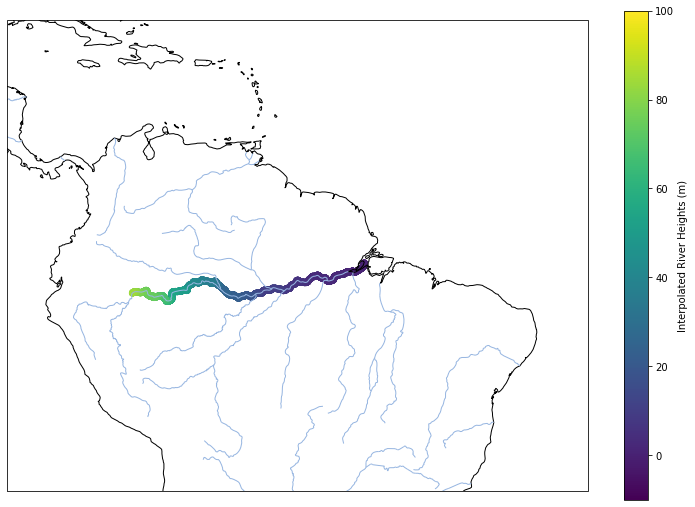

In [29]:
fig = plt.figure(figsize=[13,9]) 
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-85, -30, -20, 20])
ax.add_feature(cartopy.feature.RIVERS)

plt.scatter(ds_MEaSUREs.lon, ds_MEaSUREs.lat, lw=1, c=ds_MEaSUREs.height[:,9069])
plt.colorbar(label='Interpolated River Heights (m)')
plt.clim(-10,100)

plt.show()

For GRACE-FO, plotting lwe_thickness[107:179,34,69] indicates time, latitude, and longitude indices corresponding to the pixel for the time period 1/2019 to 12/2019 at lat/lon (-0.7, -50). For the 2019 year, measurements of LWE thickness followd expected patterns of high volume of water from the river output into the estuary.

**2011-2019 Seasonality Plots (WIP)**

For GRACE-FO, plotting lwe_thickness[107:179,34,69] indicates time, latitude, and longitude indices corresponding to the pixel for the time period 8/2011 to 12/2019 at lat/lon (-0.7, -50).

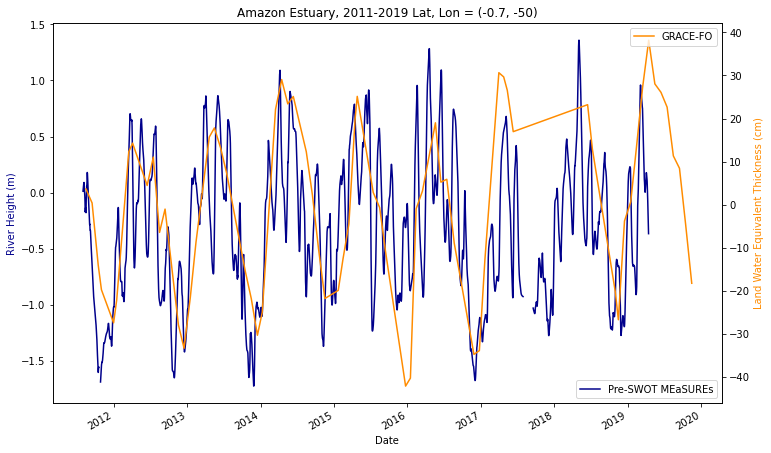

In [30]:
#plot variables associated with river
fig, ax1 = plt.subplots(figsize=[12,7])
#plot river height
ds_MEaSUREs.height[16,6689:9469].plot(color='darkblue')

#plot LWE thickness on secondary axis
ax2 = ax1.twinx()
ax2.plot(subset_GRACE.time[107:179], subset_GRACE.lwe_thickness[107:179,34,69], color = 'darkorange')

ax1.set_xlabel('Date')
ax2.set_ylabel('Land Water Equivalent Thickness (cm)', color='darkorange')
ax1.set_ylabel('River Height (m)', color='darkblue')
ax2.legend(['GRACE-FO'], loc='upper right')
ax1.legend(['Pre-SWOT MEaSUREs'], loc='lower right')

plt.title('Amazon Estuary, 2011-2019 Lat, Lon = (-0.7, -50)')

plt.show()